In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd #Basic library for all of our dataset operations
import numpy as np
import requests
import io
import statsmodels.tsa.api as smt
import statsmodels as sm
import tensorflow as tf
import pmdarima as pm
import warnings
import xgboost as xgb

import lightgbm as lgb
import gluonts
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
# # import shap
# # warnings.filterwarnings("ignore") #We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones

from utils.metrics import evaluate
from utils.plots import bar_metrics

from statsmodels.tsa.ar_model import AR
from random import random
from datetime import datetime
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn import linear_model, svm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, GridSearchCV
from math import sqrt
from xgboost import plot_importance, plot_tree
from statsmodels.tsa.arima_model import ARIMA
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from itertools import islice
from pylab import rcParams
# progress bar
from tqdm import tqdm, tqdm_notebook
# from bayes_opt import BayesianOptimization


#Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
print(tf.__version__)

Importing plotly failed. Interactive plots will not work.


2.4.0


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose

#-----------------------Imports from Sktime-------------------------
from sktime.forecasting.base import ForecastingHorizon
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.forecasting.model_selection import (
    temporal_train_test_split,
)
from sktime.utils.plotting import plot_series
from sktime.forecasting.compose import (
    TransformedTargetForecaster,
    ReducedRegressionForecaster
)

In [3]:
from datetime import datetime

In [4]:
raw_col = ['date', 'highest', 'high', 'mid', 'low', 'ave', 'ave_dif', 'volume', 'vol_dif', 'resid']
raw = pd.read_csv('FS443.csv',names=raw_col).drop(['ave_dif', 'vol_dif', 'resid'], axis=1)
for i in range(raw.shape[0]):
    raw.volume[i] = int(raw.volume[i].split(' ')[0].replace(',', ''))
raw.volume = raw.volume.values.astype('int')

ts_date = raw.copy().date
for itr in range(raw.shape[0]):
    date = raw.date[itr].split('/')
    date[0] = str(int(date[0]) + 1911)
    result = '/'.join(date)
    ts_date[itr] =  np.datetime64(datetime.strptime(result, "%Y/%m/%d").date())
    


ts = raw.copy()
ts.date = ts_date
ts['date'] = pd.to_datetime(ts['date'], errors='coerce')
ts = ts.set_index('date')
ts.index = pd.to_datetime(ts.index)
ts

,highest,high,mid,low,ave,volume
date,,,,,,
1998-12-01,195,131,77,59,84.0,327
1998-12-02,165,144,111,93,113.0,456
1998-12-03,204,160,82,65,94.0,432
1998-12-04,189,161,114,80,116.0,583
1998-12-06,181,157,90,55,96.0,1052
...,...,...,...,...,...,...
2021-01-15,305,305,305,305,305.0,48
2021-01-16,330,330,320,239,305.4,97
2021-01-18,327,327,327,327,327.0,96


In [5]:
ts.index = ts.index.to_period('D') 
# ts.ave = ts.ave + 0.001

In [6]:
y_train, y_test = ts[:-14].ave, ts[-14:].ave

In [33]:
y_train, y_test = temporal_train_test_split(store1_agg_monthly, test_size=0.2)

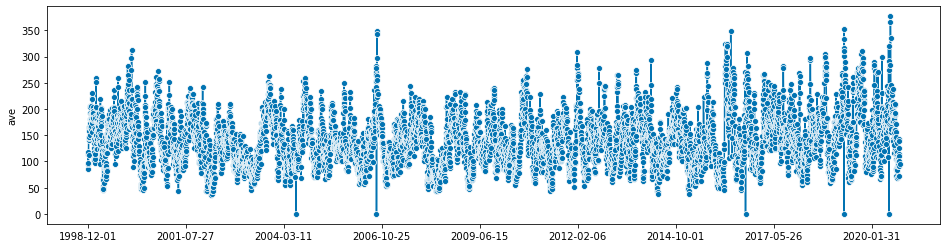

In [66]:
#Multiplicative Deseasonalizer, period = 12(for Monthly Data)
deseasonalizer = Deseasonalizer(model="multiplicative", sp=25)
plot_series(deseasonalizer.fit_transform(y_train))
seasonal = deseasonalizer.fit_transform(y_train)

In [18]:
regressor = lgb.LGBMRegressor()
forecaster = ReducedRegressionForecaster(
                    regressor=regressor, window_length=4,                               strategy="recursive" #hyper-paramter to set recursive strategy
)

In [67]:
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
                } 
#----------------------------Create Pipeline--------------------
def get_transformed_target_forecaster():
    
    #Initialize Light GBM Regressor 
    lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
                } 
    
    regressor = lgb.LGBMRegressor(**lgb_params)
#-----------------------Forecaster Pipeline-----------------
    
    #1.Separate the Seasonal Component.
    #2.Fit a forecaster for the trend.
    #3.Fit a Autoregressor to the resdiual(autoregressing on four historic values).
    
    forecaster = TransformedTargetForecaster(
        [
          
            (
                # Recursive strategy for Multi-Step Ahead Forecast.
                # Auto Regress on four previous values
                "forecast",
                ReducedRegressionForecaster(
                    regressor=regressor, window_length=4, strategy="recursive",
                ),
            ),
        ]
    )
    return forecaster

In [63]:
# #----------------------------Create Pipeline--------------------
# def get_transformed_target_forecaster(alpha,params):
    
#     #Initialize Light GBM Regressor 
    
#     regressor = lgb.LGBMRegressor(alpha = alpha,**params)
# #-----------------------Forecaster Pipeline-----------------
    
#     #1.Separate the Seasonal Component.
#     #2.Fit a forecaster for the trend.
#     #3.Fit a Autoregressor to the resdiual(autoregressing on four historic values).
    
#     forecaster = TransformedTargetForecaster(
#         [
#             ("deseasonalise", Deseasonalizer(model="multiplicative", sp=25)),
#             ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
#             (
#                 # Recursive strategy for Multi-Step Ahead Forecast.
#                 # Auto Regress on four previous values
#                 "forecast",
#                 ReducedRegressionForecaster(
#                     regressor=regressor, window_length=4, strategy="recursive",
#                 ),
#             ),
#         ]
#     )
#     return forecaster

In [7]:
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import ElasticNet

In [8]:

rfg = RandomForestRegressor( random_state=0)


BR = linear_model.BayesianRidge()


Lasso = linear_model.Lasso(alpha=0.1)


XGB = xgb.XGBRegressor(objective ='reg:squarederror',n_estimators=1000)


lgbm = lgb.LGBMRegressor()


SVR = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)


KNN = KNeighborsRegressor(n_neighbors=2)


Tweedie = TweedieRegressor()

SGD = SGDRegressor()

GBDT = GradientBoostingRegressor()

ExtraTree = ExtraTreesRegressor()

EN = ElasticNet()

rgs = [rfg, BR, Lasso, XGB, lgbm, SVR, KNN, Tweedie , GBDT, ExtraTree, EN]
names = ['rfg', 'BR', 'Lasso', 'XGB', 'lgbm', 'SVR', 'KNN', 'Tweedie', 'GBDT', 'ExtraTree', 'EN']

In [11]:
rgs = [rfg, BR, Lasso, XGB, lgbm, SVR, KNN, Tweedie , GBDT, ExtraTree, EN]
names = ['rfg', 'BR', 'Lasso', 'XGB', 'lgbm', 'SVR', 'KNN', 'Tweedie', 'GBDT', 'ExtraTree', 'EN']

In [12]:
from pytorch_forecasting.metrics import QuantileLoss, MultiLoss

In [ ]:
mse_list = []
for
for i in tqdm(range(len(rgs))):
    regressor = rgs[i]
    name = names[i]
    forecaster = ReducedRegressionForecaster(
    regressor=regressor, window_length=5, strategy="recursive"
    )
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    mse = ((y_test - y_pred) ** 2).mean()
    mse_list.append(mse)
    
    print(names[i], 'RMSE: {}'.format(round(np.sqrt(mse), 2)))

In [10]:
mse_list = []
for i in tqdm(range(len(rgs))):
    regressor = rgs[i]
    name = names[i]
    forecaster = ReducedRegressionForecaster(
    regressor=regressor, window_length=5, strategy="recursive"
    )
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    mse = ((y_test - y_pred) ** 2).mean()
    mse_list.append(mse)
    
    print(names[i], 'RMSE: {}'.format(round(np.sqrt(mse), 2)))

  9%|███████▌                                                                           | 1/11 [00:04<00:43,  4.32s/it]

rfg RMSE: nan


 18%|███████████████                                                                    | 2/11 [00:06<00:25,  2.87s/it]

BR RMSE: nan


 27%|██████████████████████▋                                                            | 3/11 [00:08<00:19,  2.40s/it]

Lasso RMSE: nan


 36%|██████████████████████████████▏                                                    | 4/11 [00:16<00:33,  4.77s/it]

XGB RMSE: nan


 45%|█████████████████████████████████████▋                                             | 5/11 [00:18<00:22,  3.73s/it]

lgbm RMSE: nan


 55%|█████████████████████████████████████████████▎                                     | 6/11 [00:25<00:23,  4.77s/it]

SVR RMSE: nan


 64%|████████████████████████████████████████████████████▊                              | 7/11 [00:27<00:15,  3.88s/it]

KNN RMSE: nan


 73%|████████████████████████████████████████████████████████████▎                      | 8/11 [00:29<00:09,  3.27s/it]

Tweedie RMSE: nan


 82%|███████████████████████████████████████████████████████████████████▉               | 9/11 [00:31<00:06,  3.13s/it]

GBDT RMSE: nan


 91%|██████████████████████████████████████████████████████████████████████████▌       | 10/11 [00:35<00:03,  3.41s/it]

ExtraTree RMSE: nan


100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:37<00:00,  3.44s/it]

EN RMSE: nan


In [12]:
mse_list = []
for i in tqdm(range(len(rgs))):
    regressor = rgs[i]
    name = names[i]
    forecaster = ReducedRegressionForecaster(
    regressor=regressor, window_length=5, strategy="recursive"
    )
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    forecaster.fit(y_train)
    y_pred = forecaster.predict(fh)
    mse = ((y_test - y_pred) ** 2).mean()
    mse_list.append(mse)
    
    print(names[i], 'RMSE: {}'.format(round(np.sqrt(mse), 2)))

  8%|██████▉                                                                            | 1/12 [00:04<00:49,  4.46s/it]

rfg RMSE: 36.51


 17%|█████████████▊                                                                     | 2/12 [00:06<00:28,  2.81s/it]

BR RMSE: 29.39


 25%|████████████████████▊                                                              | 3/12 [00:07<00:21,  2.33s/it]

Lasso RMSE: 29.39


 33%|███████████████████████████▋                                                       | 4/12 [00:14<00:31,  3.92s/it]

XGB RMSE: 42.37


 42%|██████████████████████████████████▌                                                | 5/12 [00:16<00:22,  3.21s/it]

lgbm RMSE: 37.79


 50%|█████████████████████████████████████████▌                                         | 6/12 [00:22<00:26,  4.38s/it]

SVR RMSE: 34.07


 58%|████████████████████████████████████████████████▍                                  | 7/12 [00:24<00:17,  3.51s/it]

KNN RMSE: 36.19


 67%|███████████████████████████████████████████████████████▎                           | 8/12 [00:26<00:11,  2.97s/it]

Tweedie RMSE: 29.39


 75%|██████████████████████████████████████████████████████████████▎                    | 9/12 [00:28<00:07,  2.66s/it]

SGD RMSE: inf


 83%|████████████████████████████████████████████████████████████████████▎             | 10/12 [00:30<00:05,  2.62s/it]

GBDT RMSE: 37.7


 92%|███████████████████████████████████████████████████████████████████████████▏      | 11/12 [00:34<00:02,  2.83s/it]

ExtraTree RMSE: 36.5


100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:36<00:00,  3.01s/it]

EN RMSE: 29.37


In [ ]:
lgb.LGBMRegressor()

In [97]:
from sklearn.neighbors import KNeighborsRegressor
lgb_params = {
                'boosting_type': 'gbdt',
                'objective': 'tweedie',
                'tweedie_variance_power': 1.1,
                'metric': 'rmse',
                'subsample': 0.5,
                'subsample_freq': 1,
                'learning_rate': 0.03,
                'num_leaves': 2**11-1,
                'min_data_in_leaf': 2**12-1,
                'feature_fraction': 0.5,
                'max_bin': 100,
                'n_estimators': 1400,
                'boost_from_average': False,
                'verbose': -1,
            } 

regressor = lgb.LGBMRegressor(**lgb_params)
forecaster = ReducedRegressionForecaster(
    regressor=regressor, window_length=5, strategy="recursive"
)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
mse = ((y_test - y_pred) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=4095, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4095
The Root Mean Squared Error of our forecasts is nan


In [102]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=25, n_jobs=-1)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
mse = ((y_test - y_pred) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 1440.8


In [103]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor()
forecaster = ReducedRegressionForecaster(
    regressor=regressor, window_length=5, strategy="recursive"
)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
mse = ((y_test - y_pred) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 20.58


ForecastingHorizon(['2020-11-16', '2020-11-17', '2020-11-18', '2020-11-19',
             '2020-11-20', '2020-11-21', '2020-11-23', '2020-11-24',
             '2020-11-25', '2020-11-26', '2020-11-27', '2020-11-28',
             '2020-11-30', '2020-12-01'],
            dtype='period[D]', name='date', freq='D', is_relative=False)

In [108]:
from sktime.forecasting.compose import DirectRegressionForecaster

regressor = KNeighborsRegressor()
forecaster = DirectRegressionForecaster(
    regressor=regressor, window_length=5
)
fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
mse = ((y_test - y_pred) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

ValueError: The forecasting horizon `fh` must be passed to `fit`, but none was found. This is because fitting of the `DirectRegressionForecaster` depends on `fh`. 

In [68]:
#-------------------Fitting an Auto Regressive Light-GBM------------
#Setting Quantile Regression Hyper-parameter.
# params = {
#     'objective':'quantile'
# }

#Iterate for each quantile.

forecaster = get_transformed_target_forecaster()

#Initialize ForecastingHorizon class to specify the horizon of forecast
fh = ForecastingHorizon(y_test.index, is_relative=False)

#Fit on Training data.
forecaster.fit(y_train)

#Forecast the values.
y_pred = forecaster.predict(fh)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=4095, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4095


In [69]:
mse = ((y_test - y_pred) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 34.34


In [52]:
mse = ((y_test - y_pred) ** 2).mean()

print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 36.29


In [51]:
y_test

date
2020-11-16     80.7
2020-11-17    116.6
2020-11-18    103.3
2020-11-19     93.6
2020-11-20    100.5
2020-11-21    113.7
2020-11-23    137.7
2020-11-24    140.7
2020-11-25    169.4
2020-11-26    134.9
2020-11-27    111.8
2020-11-28    166.7
2020-11-30    122.4
2020-12-01    200.5
Freq: D, Name: ave, dtype: float64

In [49]:
y_pred

2020-11-16     96.085985
2020-11-17    100.421574
2020-11-18    102.885921
2020-11-19    101.348329
2020-11-20    104.221539
2020-11-21    107.136200
2020-11-23    109.174803
2020-11-24    109.174803
2020-11-25    109.382608
2020-11-26    109.382608
2020-11-27    109.382608
2020-11-28    109.382608
2020-11-30    109.382608
2020-12-01    109.382608
Freq: D, dtype: float64

In [34]:
#-------------------Fitting an Auto Regressive Light-GBM------------
#Setting Quantile Regression Hyper-parameter.
params = {
    'objective':'quantile'
}
#A 10 percent and 90 percent prediction interval(0.1,0.9 respectively).
quantiles = [.1, .5, .9] #Hyper-parameter "alpha" in Light GBM
#Capture forecasts for 10th/median/90th quantile, respectively.
forecasts = []
#Iterate for each quantile.
for alpha in quantiles:
    
    forecaster = get_transformed_target_forecaster(alpha,params)
    
    #Initialize ForecastingHorizon class to specify the horizon of forecast
    fh = ForecastingHorizon(y_test.index, is_relative=False)
    
    #Fit on Training data.
    forecaster.fit(y_train)
    
    #Forecast the values.
    y_pred = forecaster.predict(fh)
    
    #List of forecasts made for each quantile.
    y_pred.index.name="date"
    y_pred.name=f"predicted_sales_q_{alpha}"
    forecasts.append(y_pred)
    
#Append the actual data for plotting.
store1_agg_monthly.index.name = "date"
store1_agg_monthly.name = "original"
forecasts.append(store1_agg_monthly)

In [36]:
plot_data = pd.melt(pd.concat(forecasts,axis=1).reset_index(), id_vars=['date'],\
        value_vars=['predicted_sales_q_0.1', 'predicted_sales_q_0.5',
                   'predicted_sales_q_0.9','original'])
plot_data['date'] = pd.to_datetime(plot_data['date'].astype(str).to_numpy())
plot_data['if_original'] = plot_data['variable'].apply(
    lambda r:'original' if r=='original' else 'predicted' 
)

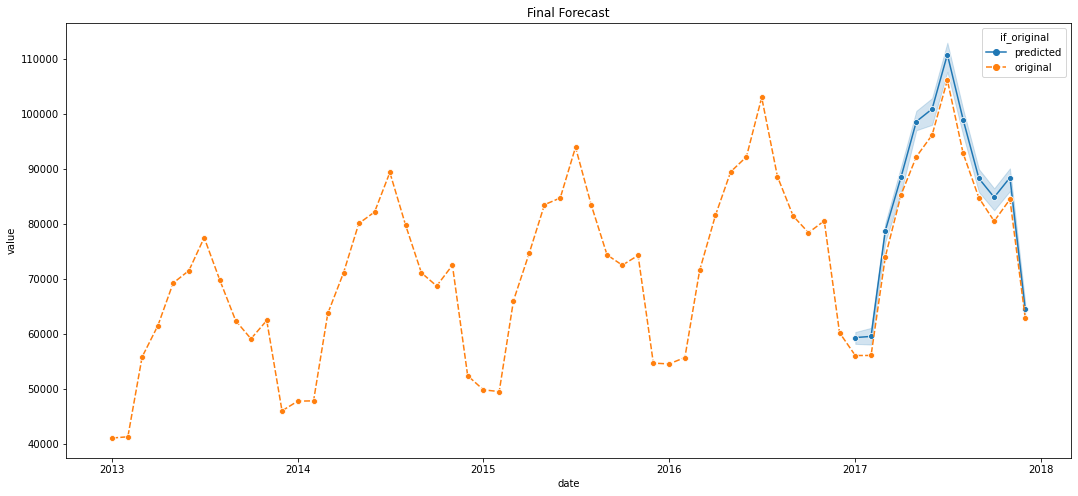

In [21]:
#-------------------Final Plotting of Forecasts------------------

plot_data = pd.melt(pd.concat(forecasts,axis=1).reset_index(), id_vars=['date'],\
        value_vars=['predicted_sales_q_0.1', 'predicted_sales_q_0.5',
                   'predicted_sales_q_0.9','original'])
plot_data['date'] = pd.to_datetime(plot_data['date'].astype(str).to_numpy())
plot_data['if_original'] = plot_data['variable'].apply(
    lambda r:'original' if r=='original' else 'predicted' 
)
sns.lineplot(data = plot_data,
        x='date',
        y='value',
        hue='if_original',
             style="if_original",
        markers=['o','o'],
)
plt.title("Final Forecast")
plt.show()